## Mid-Bootcamp Project - Lending Club

For this Mid-Bootcamp Project I am using a dataset from the LendingClub. The LendingClub is a US Peer-to-Peer lending platform offering personal loans up to 40.000 dollars. 
Members can apply for loans for almost any purpose, like a wedding, holidays, creditcard payments or debt consolidation. Investors can partially invest in a loan from a 1000 dollars and up. the LendingClub creates a win-win situation where members applying for a loan can profit from intrest rates lower than banks and for investors it is a lucrative business to make money on their personal capital instead of being dependent on a stock market.

However, investing in loans at the LendingClub is not without risk. First of all the personal loans are unsecured, meaning that if a loan defaults a investors loses their personal funds. In addition, often there are multiple investors investing in one loan, which will lead to loss of personal funds for multiple investors when one loans defaults. Furthermore, members applying for a personal loan don't have to give any collatoral or pay any prepayments and in addition members pay low interest rates, leaving little room of default buffers. 

As there is so much personal loss involved in defaulted loans at the LendingClub (LC), the LC is very much dependent on the trust investors have in their platform. When a lot of loan defaults and multiple investors lose their full investment, the LC will take a big hit on their reputation and investors will lose in the platform. No trust means no investors, means no loans and  without that there is no platform anymore. Given these facts the LC should do everthing in its power to minimize the amount of defaults. To help the LC in minimizing this a prediction model can be created to identidy potential defaulters and eliminate them. This brings us to the research question of this project:

## 'What member features predict a loan default?'

To answer this question we will start with cleaning the data and visuzaling it, before we can start building the model. In this part of the notebooks I will clean the data. In this dataset we have information in loans from 2007-2016 captured in 111 columns. 

## Cleaning the data

In this notebook I will be cleaning the data to get it ready for data visualization, preprocessing and creating the prediction model. 

In [1]:
#importing important libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## First look at the data

In [2]:
#As this data set is very very big, I had to import it using low_memories and skip_rows
df = pd.read_csv('LoanStats3a.csv',low_memory=False,skiprows=1)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
df['member_id'].nunique()

42535

In [4]:
#There are 111 columns, too many for a detailed analysis. Let's have a closer look. 
df.shape

(42538, 111)

In [5]:
# all the columns already have the snake case format, so that does not require any cleaning. 

## Visualize the target variable

In [6]:
#Let's first have a look at the target variable
df['loan_status'].value_counts()

Fully Paid                                             34085
Charged Off                                             5662
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                   19
Late (31-120 days)                                         9
In Grace Period                                            8
Late (16-30 days)                                          2
Default                                                    1
Name: loan_status, dtype: int64

In [7]:
# as we can see above there are multiple values for loan status. 
# for this research question we are interested in the factor influencing whether someone pays in time or defaults. 
# It would however also be intersting to see what factors influence if someone pays too late, given the time for this project I will not analyse this, but will take it into future research references
# Because of this we are only keeping the values 'Fully Paid' and 'Charged Off' in this dataset. 

df = df[(df['loan_status']=='Fully Paid')| (df['loan_status']=='Charged Off')]
df['loan_status']


0         Fully Paid
1        Charged Off
2         Fully Paid
3         Fully Paid
5         Fully Paid
            ...     
39781     Fully Paid
39782     Fully Paid
39783     Fully Paid
39784     Fully Paid
39785     Fully Paid
Name: loan_status, Length: 39747, dtype: object

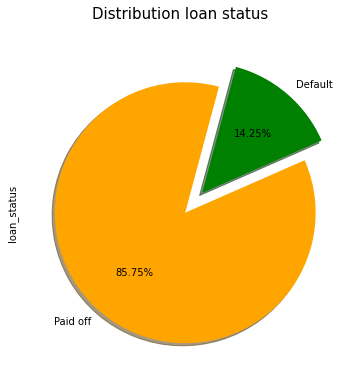

In [8]:
# let's have a look at distribution of the target variable
labels = 'Paid off','Default'
colors = ['orange', 'green']

plt.figure(figsize=(6,6))
plt.suptitle('Distribution loan status', fontsize=15)

df['loan_status'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.2f%%', shadow=True, colors=colors, 
                                             labels=labels, fontsize=10,startangle=75)

plt.show()


The plot above shows that there is a heavy imbalance between the amount of loans that is paid off and that have been defaulted. This imbalance can heavily impact our prediction model in a later stage. For now I am going to have a look what columns in the current dataset might have an influence on our target and I will get rid of columns that are not useful. As there are 111 columns in total, there should be quite a few I can exclude from the analysis. 

## Dropping columns with high percentage of NaNs

In [9]:
df.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39747
total_bal_ex_mort             39747
total_bc_limit                39747
total_il_high_credit_limit    39747
Length: 111, dtype: int64

In [10]:
#As the code below shows, there are quite some columns with NaN values, some are even completely empty.
#As columns with a high number of NaN values are not very useful I am going to drop all columns that have more than 25% NaN values

perc = 25.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna( axis=1, 
                thresh=min_count)
df.shape

(39747, 53)

## Exploring & Dropping unuseful columns

By deleting all the columns with more than 25% NaN values, we only have 53 (almost half) of the columns left. 
In this section I am having a closer look to the remaining columns to see what information they contain. 

In [11]:
df.iloc[0]

id                                                                      1077501
member_id                                                             1296599.0
loan_amnt                                                                5000.0
funded_amnt                                                              5000.0
funded_amnt_inv                                                          4975.0
term                                                                  36 months
int_rate                                                                 10.65%
installment                                                              162.87
grade                                                                         B
sub_grade                                                                    B2
emp_title                                                                   NaN
emp_length                                                            10+ years
home_ownership                          

In [12]:
#looking at the above I can already see that the URL column won't be giving me any information for analysis purposes
#as this column is only leading me to the place where the data is scraped

df = df.drop(['url'],axis=1)

With this dataset there is also a provided column description dataset that I'll use to make more sense of the remaining columns. This description dataset shows us that there is also information about loans AFTER the loans are accepted and given out. However, this information is not available for potential investors when a member is applying for a loan with them. Also, as these columns contain information making someone more likely to default or not, these columns are leaking through information to our prediction model influencing the results by impacting the reliabilty of the predictions. For this reason I will be dropping these columns. 

In [13]:
column_info = pd.read_excel('LCDataDictionary.xlsx')
column_info.set_index('LoanStatNew', inplace=True)
column_info.head()

,Description
LoanStatNew,
acc_now_delinq,The number of accounts on which the borrower i...
acc_open_past_24mths,Number of trades opened in past 24 months.
addr_state,The state provided by the borrower in the loan...
all_util,Balance to credit limit on all trades
annual_inc,The self-reported annual income provided by th...


## Looking at the first 25 columns

Let's select the first half (25 colums) to get more info

In [14]:
first_25 = ['id','member_id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','grade','sub_grade','emp_title','emp_length','home_ownership','annual_inc','verification_status','issue_d','loan_status','pymnt_plan','purpose','title','zip_code','addr_state','dti','delinq_2yrs','earliest_cr_line']
pd.set_option('display.max_colwidth', None)
column_info.loc[first_25]

,Description
LoanStatNew,
id,A unique LC assigned ID for the loan listing.
member_id,A unique LC assigned Id for the borrower member.
loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
funded_amnt,The total amount committed to that loan at that point in time.
funded_amnt_inv,The total amount committed by investors for that loan at that point in time.
term,The number of payments on the loan. Values are in months and can be either 36 or 60.
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if the loan originates.
grade,LC assigned loan grade


Looking at the first 25 columns above, I decide to drop 'id' & 'member_id'. As for the research question in this project we are only interested in the member features that predict a default and not in specific members defaulting, but for the analysis it has no use to keep these columns. 
I will also drop 'funded_amnt', 'funded_amnt_inv' and 'Issued_d' as these columns contain future information after the loan is granted.  
Lastly, I'll be dropping 'zipcode' as this info is redundant as wel already have the state (addr_state) where a member lives.

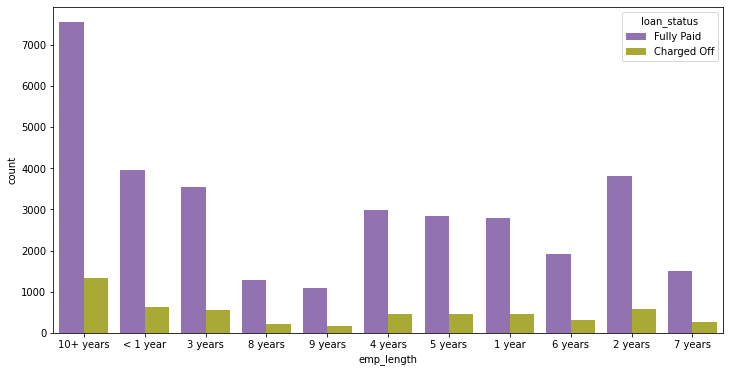

In [15]:
# there are a few I want to have a closer look at: 'emp_length' and 'sub_grade' and 'grade', 'delinq_2yrs' as I am not sure if they are useful or not
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='emp_length', hue=df['loan_status'], palette=["C4", "C8"])
plt.show()

In [16]:
# looking at the graph I can make a guess that the ratio between charged off and fully paid for employment years is not very different per amount of years
# For this reason I will drop this feature as well. 



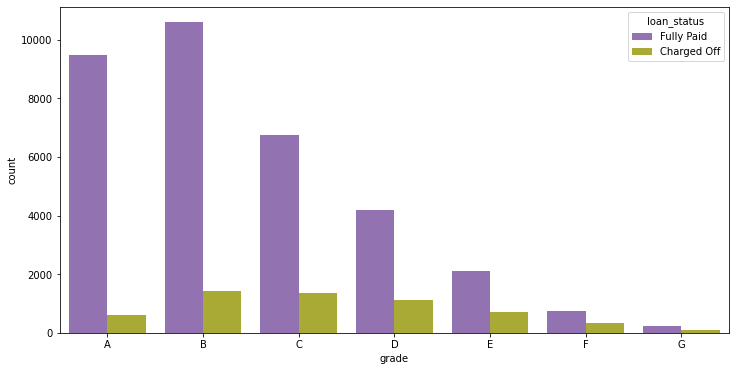

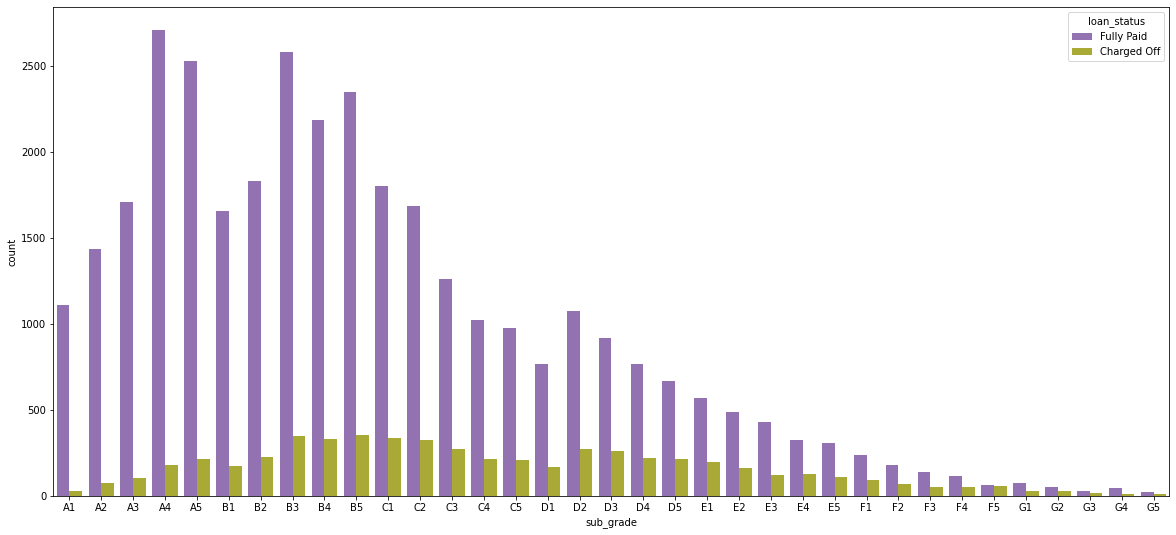

In [17]:
#looking at subgrade and grade
plt.figure(figsize=(12,6))
sorted_grade = sorted(df['grade'].unique())
sns.countplot(data=df, x='grade', order=sorted_grade, hue=df['loan_status'], palette=["C4", "C8"])
plt.show()

plt.figure(figsize=(20,9))
sorted_sub = sorted(df['sub_grade'].unique())
sns.countplot(data=df, x='sub_grade', order=sorted_sub, hue=df['loan_status'], palette=["C4", "C8"])
plt.show()

#here we can see that the grades E, F and G have the highest ratio of Charged Off loans. 
# as the subgrades gives a more granular view and therefore more detailed info on the defaulter I will keep this column and drop 'grade'

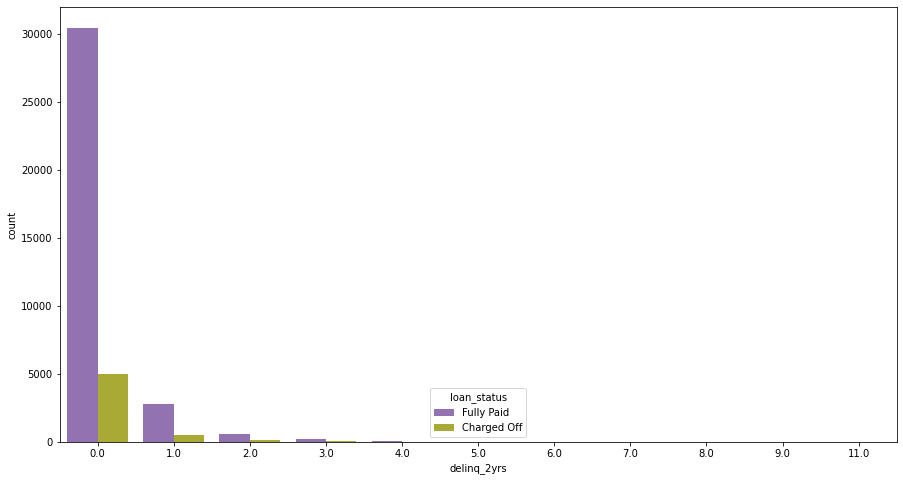

In [18]:
#looking at delinq2_years
# the ratio of charged off and the amount of delinquents in the last 2 years seems to be quite high in this graph, for that reason I think this is an interesting column to keep
plt.figure(figsize=(15,8))
sns.countplot(data=df, x='delinq_2yrs', hue=df['loan_status'], palette=["C4", "C8"])
plt.show()

After analysing the first 25 columns, I will not be taking the following into my analysis:
- id
- member_id
- funded_amnt
- funded_amnt_inv
- Issed_d
- Zipcode
- emp_length
- grade


## Looking at the last 27 columns

Let's have a look at the last 27 columns. 

In [19]:
last_27 = ['inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','pub_rec_bankruptcies','tax_liens']
column_info.loc[last_27]

,Description
LoanStatNew,
inq_last_6mths,The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
open_acc,The number of open credit lines in the borrower's credit file.
pub_rec,Number of derogatory public records
revol_bal,Total credit revolving balance
revol_util,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."
total_acc,The total number of credit lines currently in the borrower's credit file
initial_list_status,"The initial listing status of the loan. Possible values are – W, F"
out_prncp,Remaining outstanding principal for total amount funded
out_prncp_inv,Remaining outstanding principal for portion of total amount funded by investors


Looking at the second 27 columns there are quite a few future columns that I will drop, namely: 'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d' and 'last_pymnt_amnt'.
I am going to have a closer look at pub_rec' as I am not sure how what the relationship between this column and my target is. 


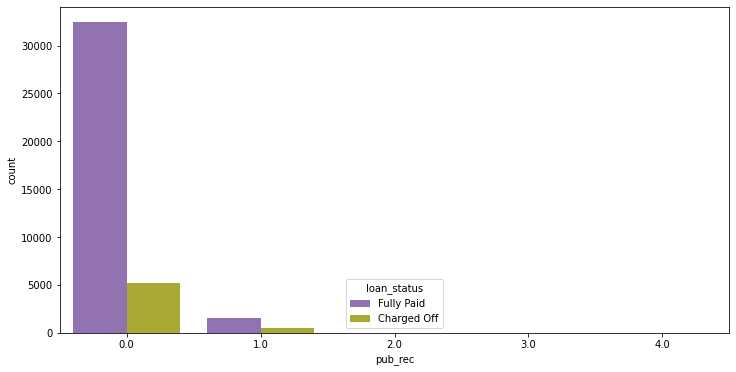

In [20]:
#Looking at the graph I can see that half of the members that has a public record of derogatory also defaulted on their loans, therefore this is an interesting column to keep
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='pub_rec', hue=df['loan_status'], palette=["C4", "C8"])
plt.show()

From the last 27 columns we will dropping the following:

- out_prncp
- out_prncp_inv
- total_pymnt
- total_pymnt_inv
- total_rec_prncp
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt

In [21]:
#dropping non_futures
df = df.drop(['id','member_id','zip_code','grade','issue_d','emp_length'],axis=1)
df.to_csv('loans_withfutureinfo.csv')

# saving a copy with the columns containing the future info as I might want to use them later as a target.
df_copy = df.copy()

In [22]:
#dropping future columns

df = df.drop(['funded_amnt','funded_amnt_inv','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt'],axis=1)

In [23]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_title,home_ownership,annual_inc,verification_status,loan_status,...,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000.0,36 months,10.65%,162.87,B2,NaN,RENT,24000.0,Verified,Fully Paid,...,f,Dec-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,2500.0,60 months,15.27%,59.83,C4,Ryder,RENT,30000.0,Source Verified,Charged Off,...,f,Oct-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,2400.0,36 months,15.96%,84.33,C5,NaN,RENT,12252.0,Not Verified,Fully Paid,...,f,Dec-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,10000.0,36 months,13.49%,339.31,C1,AIR RESOURCES BOARD,RENT,49200.0,Source Verified,Fully Paid,...,f,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
5,5000.0,36 months,7.90%,156.46,A4,Veolia Transportaton,RENT,36000.0,Source Verified,Fully Paid,...,f,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


## Looking at columns with small or high variance

In [24]:
# Here I manually check through the columns to see what value counts they have. I've noticed that there are a lot of columns that only have 1 value. 
# This won't give my model any information, so I will drop them.
df['policy_code'].value_counts()
df['chargeoff_within_12_mths'].value_counts()
df['collections_12_mths_ex_med'].nunique()
df['application_type'].nunique()
df['tax_liens'].nunique()

1

In [25]:
def singlevaluecol(x):
    for column in x.columns:
        if x[column].nunique() == 1:
            x = x.drop([column],axis=1)
    return x

df = singlevaluecol(df)

In [26]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_title', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

In [27]:
#it seems that the columns title and emp_title have a lot of value counts (almost unique) 
# I am assuming the member can fill in their employment title and loan title manually, so there will be a lot of different and also similair data in here
# like the same title but written differently. Because this will lead to noise in our analysis we will delete them
# the employment title would be interesting to have as a categories, however this is not a priority at the moment
print(df['emp_title'].nunique())
print(df['title'].nunique())

28832
19632


In [28]:
df = df.drop(['emp_title','title'],axis=1)

In [29]:
#we are nog left with only 25 columns
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies
0,5000.0,36 months,10.65%,162.87,B2,RENT,24000.0,Verified,Fully Paid,credit_card,...,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,Dec-2016,0.0
1,2500.0,60 months,15.27%,59.83,C4,RENT,30000.0,Source Verified,Charged Off,car,...,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,Oct-2016,0.0
2,2400.0,36 months,15.96%,84.33,C5,RENT,12252.0,Not Verified,Fully Paid,small_business,...,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,Dec-2016,0.0
3,10000.0,36 months,13.49%,339.31,C1,RENT,49200.0,Source Verified,Fully Paid,other,...,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,Apr-2016,0.0
5,5000.0,36 months,7.90%,156.46,A4,RENT,36000.0,Source Verified,Fully Paid,wedding,...,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3%,12.0,Jan-2016,0.0


## Dealing with NaN values

After narrowing done the number of columns, I will have a look at the remaining NaN values and deal with them accordingly.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39747 entries, 0 to 39785
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39747 non-null  float64
 1   term                  39747 non-null  object 
 2   int_rate              39747 non-null  object 
 3   installment           39747 non-null  float64
 4   sub_grade             39747 non-null  object 
 5   home_ownership        39747 non-null  object 
 6   annual_inc            39747 non-null  float64
 7   verification_status   39747 non-null  object 
 8   loan_status           39747 non-null  object 
 9   purpose               39747 non-null  object 
 10  addr_state            39747 non-null  object 
 11  dti                   39747 non-null  float64
 12  delinq_2yrs           39747 non-null  float64
 13  earliest_cr_line      39747 non-null  object 
 14  inq_last_6mths        39747 non-null  float64
 15  open_acc           

In [31]:
df.isna().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util               50
total_acc                 0
last_credit_pull_d        2
pub_rec_bankruptcies    697
dtype: int64

The only NaN values we have are in the columns 'revol_util', 'last_credit_pull_d' and 'pub_rec_bankruptcies'.
'revol_util' is a percentage, 'last_credit_pull_d' a date and 'pub_rec_bankruptcies' is a discrete value (as it has only 3 values, which are counted).
I'll first have to transform revol_util back to a float so I can fill the NaN's with the mean. 'last_credit_pull_d' and 'pub_rec_bankruptcies' I will fill with the mode as the one is an object and the other only has 3 counted values, so filling them with the mean will probably give a new value, not in line with the 3 values that are already there. 

In [32]:
df['last_credit_pull_d'].fillna(df['last_credit_pull_d'].mode()[0], inplace=True)
df['pub_rec_bankruptcies'].fillna(df['pub_rec_bankruptcies'].mode()[0], inplace=True)

In [33]:
# changing revol_util to a float
df['revol_util'] = df['revol_util'].str.replace('\%','')
df['revol_util'] =  pd.to_numeric(df['revol_util'], errors='coerce')
df['revol_util'] = (df['revol_util']) /100

/var/folders/ds/zk5fgzhx7b53nll390cs5phh0000gn/T/ipykernel_48407/2653393012.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['revol_util'] = df['revol_util'].str.replace('\%','')


In [34]:
# filling NaNs for revol_util with the mean
df['revol_util'].fillna(df['revol_util'].mean(), inplace=True)

In [35]:
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
addr_state              0
dti                     0
delinq_2yrs             0
earliest_cr_line        0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
last_credit_pull_d      0
pub_rec_bankruptcies    0
dtype: int64

## Turning target variable into a binary variable

In order to be able to use the target variable in the prediction model, it needs to be a binary column. As I am still in the cleaning phase I will transform it now.

In [36]:
def binary_status(x):
    if x == 'Fully Paid':
        return 0
    else:
        return 1

df['loan_status'] = df['loan_status'].apply(binary_status)

In [37]:
df['loan_status'].value_counts()

0    34085
1     5662
Name: loan_status, dtype: int64

## Exploring categorical variables

Next I am going to have a look at the categorical variables to have a look if I can clean up the values, or if some need can be added together to reduce the amount of values. 

In [38]:
df.select_dtypes(include=object)

,term,int_rate,sub_grade,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,last_credit_pull_d
0,36 months,10.65%,B2,RENT,Verified,credit_card,AZ,Jan-1985,Dec-2016
1,60 months,15.27%,C4,RENT,Source Verified,car,GA,Apr-1999,Oct-2016
2,36 months,15.96%,C5,RENT,Not Verified,small_business,IL,Nov-2001,Dec-2016
3,36 months,13.49%,C1,RENT,Source Verified,other,CA,Feb-1996,Apr-2016
5,36 months,7.90%,A4,RENT,Source Verified,wedding,AZ,Nov-2004,Jan-2016
...,...,...,...,...,...,...,...,...,...
39781,36 months,8.07%,A4,MORTGAGE,Not Verified,home_improvement,CO,Nov-1990,Jun-2010
39782,36 months,10.28%,C1,RENT,Not Verified,credit_card,NC,Dec-1986,Jul-2010
39783,36 months,8.07%,A4,MORTGAGE,Not Verified,debt_consolidation,MA,Oct-1998,Jun-2007
39784,36 months,7.43%,A2,MORTGAGE,Not Verified,other,MD,Nov-1988,Jun-2007


In [39]:
# First of all we can change term by removing the month making it just a number, however as there are only 2 values in there I might as well one hot encode it

In [40]:
#Same as the revol_rate, int_rate is a percentage and is supposed to be a number and not an object, so i'll transform it
df['int_rate'] = df['int_rate'].str.replace('\%','')
df['int_rate'] = pd.to_numeric(df['int_rate'], errors='coerce')
df['int_rate'] = (df['int_rate']) /100

/var/folders/ds/zk5fgzhx7b53nll390cs5phh0000gn/T/ipykernel_48407/1439221869.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['int_rate'] = df['int_rate'].str.replace('\%','')


In [41]:
# Looking at the home_ownership column we can see the following:
#Other and None both have very low value counts and can be put together in one category 'other'
df['home_ownership'].value_counts()

RENT        18897
MORTGAGE    17686
OWN          3063
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

In [42]:
def clean_home(x):
    if x == 'NONE':
        return 'OTHER'
    else:
        return x

df['home_ownership'] = df['home_ownership'].apply(clean_home)

In [43]:
df['home_ownership'].value_counts()

RENT        18897
MORTGAGE    17686
OWN          3063
OTHER         101
Name: home_ownership, dtype: int64

In [44]:
#This column can be made smaller by adding some values together, so we can reduce the noise in the analysis
df['purpose'].value_counts()

debt_consolidation    18651
credit_card            5132
other                  3998
home_improvement       2984
major_purchase         2187
small_business         1827
car                    1551
wedding                 948
medical                 695
moving                  583
house                   382
vacation                381
educational             325
renewable_energy        103
Name: purpose, dtype: int64

In [45]:
def clean_purpose(x):
    if x == 'moving':
        return 'home_improvement'
    elif x == 'house':
        return 'home_improvement'
    elif x == 'renewable_energy':
        return 'home_improvement'
    elif x == 'wedding':
        return 'leisure'
    elif x == 'vacation':
        return 'leisure'
    else:
        return x

df['purpose'] = df['purpose'].apply(clean_purpose)
    

In [46]:
df['purpose'].value_counts()

debt_consolidation    18651
credit_card            5132
home_improvement       4052
other                  3998
major_purchase         2187
small_business         1827
car                    1551
leisure                1329
medical                 695
educational             325
Name: purpose, dtype: int64

In [47]:
# let's have a look at the residential states of the members. 
df['addr_state'].value_counts()

CA    7101
NY    3813
FL    2869
TX    2732
NJ    1850
IL    1524
PA    1518
VA    1407
GA    1398
MA    1343
OH    1226
MD    1054
AZ     881
WA     841
CO     791
NC     787
CT     753
MI     722
MO     686
MN     616
NV     498
SC     472
WI     459
AL     450
OR     449
LA     436
KY     327
OK     300
KS     272
UT     258
AR     246
DC     214
RI     199
NM     189
WV     177
HI     174
NH     172
DE     114
MT      85
WY      83
AK      79
SD      64
VT      54
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: addr_state, dtype: int64

In [48]:
# I'll combine the states into their regions so I won't lose the info but also don't have too many columns
def clean_state_west(x):
    if x == 'WA':
        return 'West'
    if x == 'MT':
        return 'West'
    if x == 'OR':
        return 'West'
    if x == 'ID':
        return 'West'
    if x == 'WY':
        return 'West'
    if x == 'CA':
        return 'West'
    if x == 'NV':
        return 'West'
    if x == 'UT':
        return 'West'
    if x == 'CO':
        return 'West'
    if x == 'AK':
        return 'West'
    if x == 'HI':
        return 'West'
    else:
        return x

df['addr_state'] = df['addr_state'].apply(clean_state_west)

In [49]:
def clean_state_southwest(x):
    if x == 'AZ':
        return 'Southwest'
    if x == 'NM':
        return 'Southwest'
    if x == 'OK':
        return 'Southwest'
    if x == 'TX':
        return 'Southwest'
    else:
        return x

df['addr_state'] = df['addr_state'].apply(clean_state_southwest)

In [50]:
def clean_state_midwest(x):
    if x == 'ND':
        return 'Midwest'
    if x == 'SD':
        return 'Midwest'
    if x == 'NE':
        return 'Midwest'
    if x == 'KS':
        return 'Midwest'
    if x == 'MN':
        return 'Midwest'
    if x == 'IA':
        return 'Midwest'
    if x == 'MO':
        return 'Midwest'
    if x == 'WI':
        return 'Midwest'
    if x == 'IL':
        return 'Midwest'
    if x == 'IN':
        return 'Midwest'
    if x == 'MI':
        return 'Midwest'
    if x == 'OH':
        return 'Midwest'
    else:
        return x

df['addr_state'] = df['addr_state'].apply(clean_state_midwest)

In [51]:
def clean_state_southeast(x):
    if x == 'AR':
        return 'Southeast'
    if x == 'LA':
        return 'Southeast'
    if x == 'MS':
        return 'Southeast'
    if x == 'TN':
        return 'Southeast'
    if x == 'KY':
        return 'Southeast'
    if x == 'AL':
        return 'Southeast'
    if x == 'GA':
        return 'Southeast'
    if x == 'SC':
        return 'Southeast'
    if x == 'NC':
        return 'Southeast'
    if x == 'VA':
        return 'Southeast'
    if x == 'WV':
        return 'Southeast'
    if x == 'FL':
        return 'Southeast'
    else:
        return x

df['addr_state'] = df['addr_state'].apply(clean_state_southeast)

In [52]:
def clean_state_northeast(x):
    if x == 'NY':
        return 'Northeast'
    if x == 'NJ':
        return 'Northeast'
    if x == 'PA':
        return 'Northeast'
    if x == 'MA':
        return 'Northeast'
    if x == 'MD':
        return 'Northeast'
    if x == 'CT':
        return 'Northeast'
    if x == 'DC':
        return 'Northeast'
    if x == 'RI':
        return 'Northeast'
    if x == 'NH':
        return 'Northeast'
    if x == 'DE':
        return 'Northeast'
    if x == 'VT':
        return 'Northeast'
    if x == 'ME':
        return 'Northeast'
    else:
        return x

df['addr_state'] = df['addr_state'].apply(clean_state_northeast)

In [53]:
df['addr_state'].value_counts()

Northeast    11087
West         10365
Southeast     8605
Midwest       5588
Southwest     4102
Name: addr_state, dtype: int64

In [54]:
df.select_dtypes(object)

,term,sub_grade,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,last_credit_pull_d
0,36 months,B2,RENT,Verified,credit_card,Southwest,Jan-1985,Dec-2016
1,60 months,C4,RENT,Source Verified,car,Southeast,Apr-1999,Oct-2016
2,36 months,C5,RENT,Not Verified,small_business,Midwest,Nov-2001,Dec-2016
3,36 months,C1,RENT,Source Verified,other,West,Feb-1996,Apr-2016
5,36 months,A4,RENT,Source Verified,leisure,Southwest,Nov-2004,Jan-2016
...,...,...,...,...,...,...,...,...
39781,36 months,A4,MORTGAGE,Not Verified,home_improvement,West,Nov-1990,Jun-2010
39782,36 months,C1,RENT,Not Verified,credit_card,Southeast,Dec-1986,Jul-2010
39783,36 months,A4,MORTGAGE,Not Verified,debt_consolidation,Northeast,Oct-1998,Jun-2007
39784,36 months,A2,MORTGAGE,Not Verified,other,Northeast,Nov-1988,Jun-2007


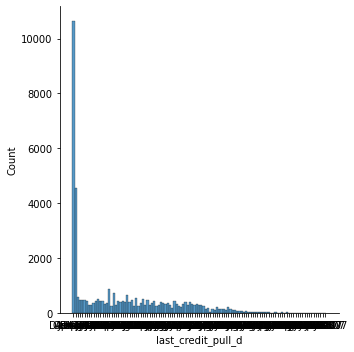

In [55]:
# as the plots below show, the date columns contain a lot of different values, making it difficult to get any valuable information from them
# for that reason I decided to split the years from the months and see the differences. 
sns.displot(x='last_credit_pull_d', data=df)
plt.show()

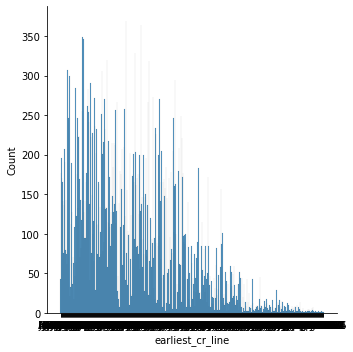

In [56]:
sns.displot(x='earliest_cr_line', data=df)
plt.show()

In [57]:
new = df['earliest_cr_line'].str.split('-', n = 1, expand = True)
df['month_cr_line'] = new[0]
df['year_cr_line'] = new[1]
df = df.drop(['earliest_cr_line'],axis=1)

In [58]:
new2 = df['last_credit_pull_d'].str.split('-',n=1,expand=True)
df['month_last_creditpull'] = new2[0]
df['year_last_creditpull'] = new2[1]
df = df.drop(['last_credit_pull_d'],axis=1)
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,month_cr_line,year_cr_line,month_last_creditpull,year_last_creditpull
0,5000.0,36 months,0.1065,162.87,B2,RENT,24000.0,Verified,0,credit_card,...,3.0,0.0,13648.0,0.837,9.0,0.0,Jan,1985,Dec,2016
1,2500.0,60 months,0.1527,59.83,C4,RENT,30000.0,Source Verified,1,car,...,3.0,0.0,1687.0,0.094,4.0,0.0,Apr,1999,Oct,2016
2,2400.0,36 months,0.1596,84.33,C5,RENT,12252.0,Not Verified,0,small_business,...,2.0,0.0,2956.0,0.985,10.0,0.0,Nov,2001,Dec,2016
3,10000.0,36 months,0.1349,339.31,C1,RENT,49200.0,Source Verified,0,other,...,10.0,0.0,5598.0,0.210,37.0,0.0,Feb,1996,Apr,2016
5,5000.0,36 months,0.0790,156.46,A4,RENT,36000.0,Source Verified,0,leisure,...,9.0,0.0,7963.0,0.283,12.0,0.0,Nov,2004,Jan,2016


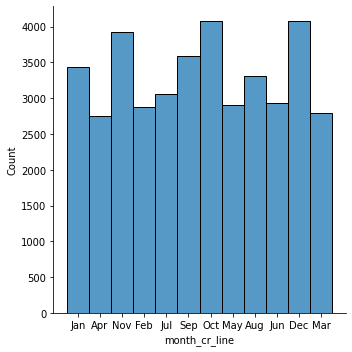

In [59]:

sns.displot(x='month_cr_line',data=df)
plt.show()

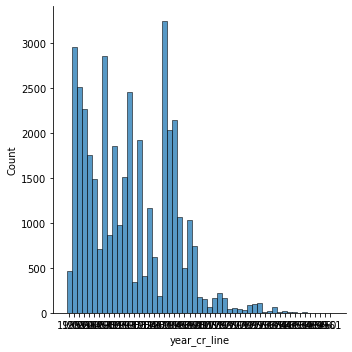

In [60]:
sns.displot(x='year_cr_line',data=df)
plt.show()

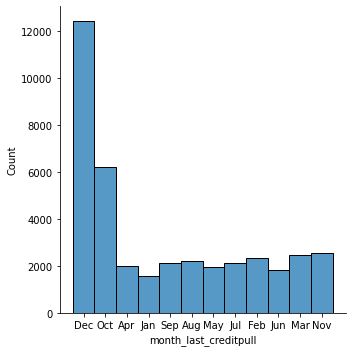

In [61]:
sns.displot(x='month_last_creditpull',data=df)
plt.show()

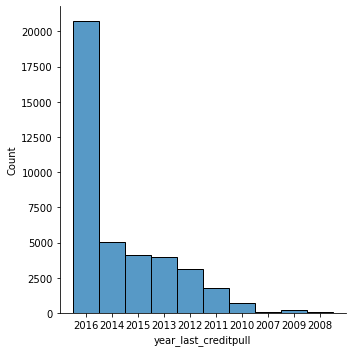

In [62]:
sns.displot(x='year_last_creditpull',data=df)
plt.show()

After conducting some more research on both date columns. I found out that 'earliest_cr_line' is the date the member got their first loan approved. The column 'last_credit_pull_d' is about the last time the Lending Club did a hard pull of a member's credits, on their website I read that they only do this pull AFTER a new loan is approved. So that means I can interpet the difference between both columns as the amount of years a member has had loans approved succesfully. 
This could be an interesting parameter that could have an influence on a member defaulting or not, as if they defaulted they probably will not have been able to loan succesfully for many years. 
I will create a new column for this as I think that this is more valuable then knowing when someone got their first or last loan approved, as this date doesn't say much about a person, but the amounnt of years they have been able to loan succesfully does.

In [63]:
df['year_last_creditpull'] = df['year_last_creditpull'].astype(int)
df['year_cr_line'] = df['year_cr_line'].astype(int)

df['years_succes_loans'] = df['year_last_creditpull'] - df['year_cr_line']

df = df.drop(['month_cr_line','year_cr_line','month_last_creditpull','year_last_creditpull'],axis=1)
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,...,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,years_succes_loans
0,5000.0,36 months,0.1065,162.87,B2,RENT,24000.0,Verified,0,credit_card,...,27.65,0.0,1.0,3.0,0.0,13648.0,0.837,9.0,0.0,31
1,2500.0,60 months,0.1527,59.83,C4,RENT,30000.0,Source Verified,1,car,...,1.00,0.0,5.0,3.0,0.0,1687.0,0.094,4.0,0.0,17
2,2400.0,36 months,0.1596,84.33,C5,RENT,12252.0,Not Verified,0,small_business,...,8.72,0.0,2.0,2.0,0.0,2956.0,0.985,10.0,0.0,15
3,10000.0,36 months,0.1349,339.31,C1,RENT,49200.0,Source Verified,0,other,...,20.00,0.0,1.0,10.0,0.0,5598.0,0.210,37.0,0.0,20
5,5000.0,36 months,0.0790,156.46,A4,RENT,36000.0,Source Verified,0,leisure,...,11.20,0.0,3.0,9.0,0.0,7963.0,0.283,12.0,0.0,12


## Transforming final columns & renaming

In [64]:
# I noticed 'annual_inc' is defined as a float, but there is no use for that, so I will transform it to an int.
df['annual_inc'].value_counts()

60000.0    1507
50000.0    1058
40000.0     875
45000.0     833
30000.0     825
           ... 
90888.0       1
56820.0       1
45314.0       1
53913.0       1
27376.0       1
Name: annual_inc, Length: 5321, dtype: int64

In [65]:
df['annual_inc'] = df['annual_inc'].astype(int)

In [66]:
#same for 'loan_amnt'
df['loan_amnt'] = df['loan_amnt'].astype(int)

In [67]:
df['loan_amnt'].value_counts()

10000    2834
12000    2339
5000     2050
6000     1907
15000    1896
         ... 
22875       1
8175        1
19475       1
21225       1
22550       1
Name: loan_amnt, Length: 884, dtype: int64

In [68]:
#DTI is a percentage but has not been dived by a 100 yet like I did for the other percentages. 
df['dti'] = (df['dti']) /100

In [69]:
#some of the column names use some abbreviations I think are unnecessary so I am changing them
df = df.rename(columns = {'total_acc':'total_accounts','open_acc':'open_accounts','revol_bal':'revol_balance','revol_util':'revol_util_rate','pub_rec':'pub_rec_derogatory','annual_inc':'annual_income'})
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_income,verification_status,loan_status,purpose,...,dti,delinq_2yrs,inq_last_6mths,open_accounts,pub_rec_derogatory,revol_balance,revol_util_rate,total_accounts,pub_rec_bankruptcies,years_succes_loans
0,5000,36 months,0.1065,162.87,B2,RENT,24000,Verified,0,credit_card,...,0.2765,0.0,1.0,3.0,0.0,13648.0,0.837,9.0,0.0,31
1,2500,60 months,0.1527,59.83,C4,RENT,30000,Source Verified,1,car,...,0.0100,0.0,5.0,3.0,0.0,1687.0,0.094,4.0,0.0,17
2,2400,36 months,0.1596,84.33,C5,RENT,12252,Not Verified,0,small_business,...,0.0872,0.0,2.0,2.0,0.0,2956.0,0.985,10.0,0.0,15
3,10000,36 months,0.1349,339.31,C1,RENT,49200,Source Verified,0,other,...,0.2000,0.0,1.0,10.0,0.0,5598.0,0.210,37.0,0.0,20
5,5000,36 months,0.0790,156.46,A4,RENT,36000,Source Verified,0,leisure,...,0.1120,0.0,3.0,9.0,0.0,7963.0,0.283,12.0,0.0,12


## Saving the dataset 

In [70]:
df.to_csv('lendingclub_cleaned.csv')

In [71]:
from sqlalchemy import create_engine
import getpass
password = getpass.getpass()

········


In [72]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/LendingClub'
engine = create_engine(connection_string)
                       
df.to_sql('loans', con=engine, if_exists='replace', index = False)
engine.execute("SELECT * FROM loans").fetchall()

[(5000, ' 36 months', 0.1065, 162.87, 'B2', 'RENT', 24000, 'Verified', 0, 'credit_card', 'Southwest', 0.27649999999999997, 0.0, 1.0, 3.0, 0.0, 13648.0, 0.8370000000000001, 9.0, 0.0, 31),
 (2500, ' 60 months', 0.1527, 59.83, 'C4', 'RENT', 30000, 'Source Verified', 1, 'car', 'Southeast', 0.01, 0.0, 5.0, 3.0, 0.0, 1687.0, 0.094, 4.0, 0.0, 17),
 (2400, ' 36 months', 0.15960000000000002, 84.33, 'C5', 'RENT', 12252, 'Not Verified', 0, 'small_business', 'Midwest', 0.0872, 0.0, 2.0, 2.0, 0.0, 2956.0, 0.985, 10.0, 0.0, 15),
 (10000, ' 36 months', 0.1349, 339.31, 'C1', 'RENT', 49200, 'Source Verified', 0, 'other', 'West', 0.2, 0.0, 1.0, 10.0, 0.0, 5598.0, 0.21, 37.0, 0.0, 20),
 (5000, ' 36 months', 0.079, 156.46, 'A4', 'RENT', 36000, 'Source Verified', 0, 'leisure', 'Southwest', 0.11199999999999999, 0.0, 3.0, 9.0, 0.0, 7963.0, 0.28300000000000003, 12.0, 0.0, 12),
 (7000, ' 60 months', 0.15960000000000002, 170.08, 'C5', 'RENT', 47004, 'Not Verified', 0, 'debt_consolidation', 'Southeast', 0.2351, 